# California hindcast validation

This notebook shows examples of accessing and validating Oceanum's California wave hindcast using the Datamesh [python client](https://oceanum-python.readthedocs.org/).

## Required python libraries

- oceanum
- matplotlib
- cartopy
- xarray
- pandas
- geopandas
- wavespectra

In [1]:
import os
import geopandas
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from wavespectra import read_dataset
from tqdm import tqdm
from datetime import datetime, timedelta

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## 1. Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector(token=None)

## 2. Oceanum hindcast datasources

Search for the hindcast datasources from Oceanum in Datamesh using the [get_catalog](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.get_catalog) method which returns a catalog with all datasources matching the searching criteria

In [3]:
cat_parameters = datamesh.get_catalog("tags:oceanum&wave&hindcast&parameters")
print(len(cat_parameters))
list(cat_parameters)

18


[
         Oceanum global ERA5 wave hindcast parameters [oceanum_wave_glob05_era5_v1_grid]
             Extent: (0.0, -77.5, 360.0, 77.5)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum Western Europe ERA5 wave hindcast parameters [oceanum_wave_weuro_era5_v1_grid]
             Extent: (-11.0, 48.5, 13.0, 61.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum New Zealand ERA5 wave hindcast parameters [oceanum_wave_nz_era5_v1_grid]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum Taranaki ERA5 wave hindcast parameters [oceanum_wave_trki_era5_v1_grid]
             Extent: (173.0, -40.0, 175.1999969482422, -37.79999923706055)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum Western Taiwan ERA5 wave hindc

### 2.1. Hindcast grids

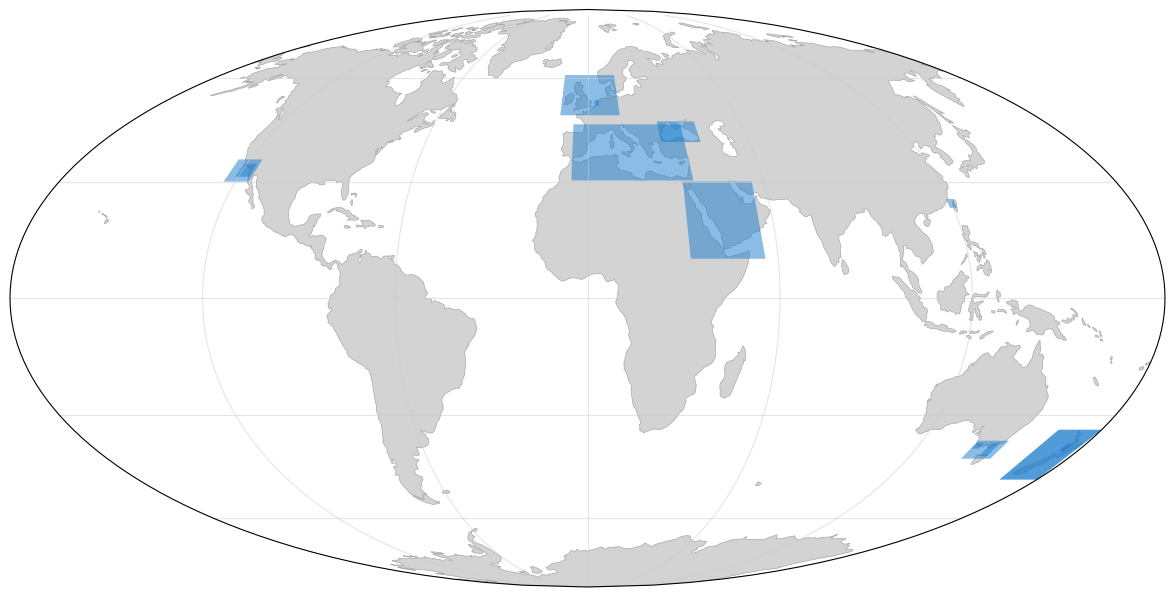

In [4]:
projection = ccrs.Mollweide(central_longitude=0)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))
ax.set_global()
for ds in cat_parameters:
    if "glob" not in ds.id:
        geopandas.GeoSeries(ds.geom).plot(ax=ax, transform=transform, color="#187bcd", alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

### 2.2. Hindcast spectra

Search, query coordinates from and show the locations of all spectra output available from Oceanum hindcast datasources

In [5]:
cat_spectra = datamesh.get_catalog("tags:oceanum&wave&hindcast&spectra")
print(len(cat_spectra))

36


In [6]:
all_coords = {}
for ds in tqdm(list(cat_spectra)):
    all_coords.update({ds.id: datamesh.query({"datasource": ds.id, "variables": ["lon", "lat"]})})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:19<00:00,  2.21s/it]


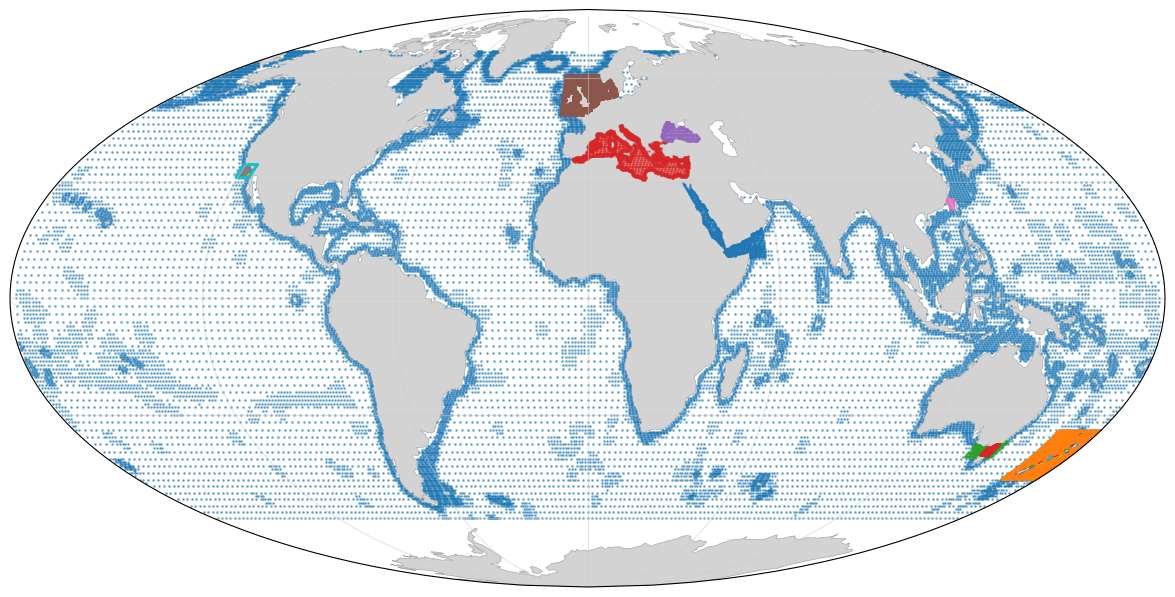

In [7]:
fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))
ax.set_global()
# Plot Global one first
coords = all_coords["oceanum_wave_glob05_era5_v1_spec"]
ax.plot(coords.lon, coords.lat, "o", markersize=1, alpha=0.5, transform=transform)
# Plot the rest
for datasource, coords in all_coords.items():
    if datasource != "oceanum_wave_glob05_era5_v1_spec":
        ax.plot(coords.lon, coords.lat, "o", markersize=1, alpha=0.5, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

## 3. Hindcast validation against NDBC buoys

Validate the [Oceanum California wave hindcast](https://datasets.oceanum.io/oceanum_sw_northamerica_wave_hindcast.pdf) 

### 3.1. Inspect the NDBC dataset
#### Search for all the near real-time NDBC spectra available in Datamesh

In [8]:
cat_ndbc = datamesh.get_catalog("ndbc nrt")
print(len(cat_ndbc))
list(cat_ndbc)[:3]

200


[
         NDBC near real time spectra site 41044 [ndbc_nrt_spectra_41044]
             Extent: (-58.61399841308594, 21.638999938964844, -58.61399841308594, 21.638999938964844)
             Timerange: 2012-10-01 00:00:00+00:00 to None
         ,
 
         NDBC near real time spectra site 41002 [ndbc_nrt_spectra_41002]
             Extent: (-74.9209976196289, 31.886999130249023, -74.9209976196289, 31.886999130249023)
             Timerange: 2020-05-29 19:06:00+00:00 to None
         ,
 
         NDBC near real time spectra site 41004 [ndbc_nrt_spectra_41004]
             Extent: (-79.0989990234375, 32.500999450683594, -79.0989990234375, 32.500999450683594)
             Timerange: 2014-04-22 18:00:00+00:00 to None
         ]

#### Plot the locations of all buoys

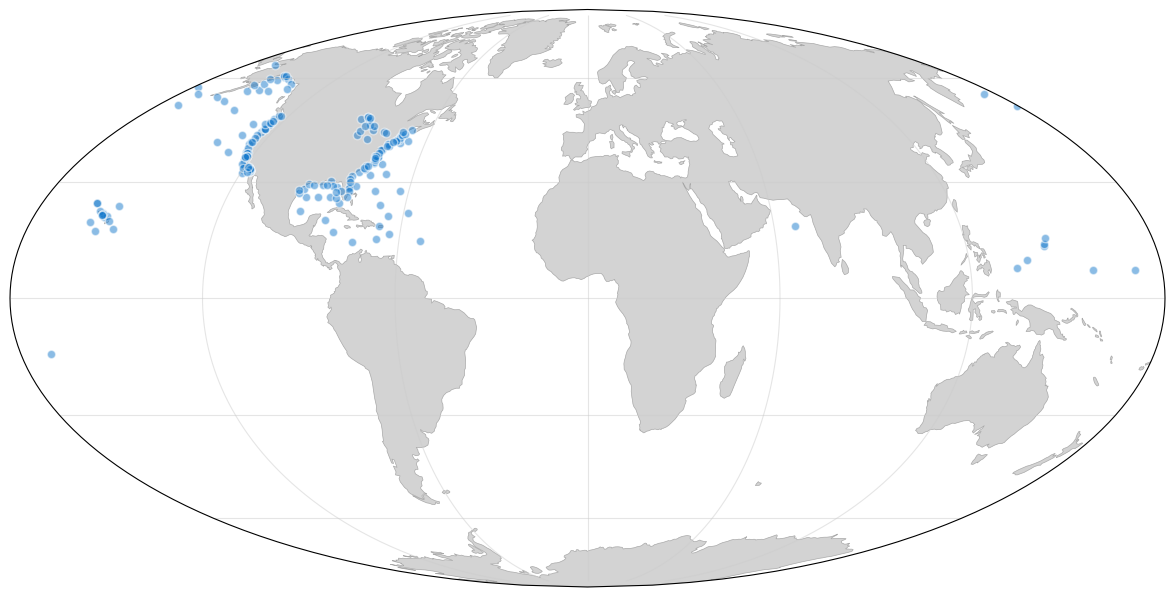

In [9]:
xb = [ds.geom.x for ds in list(cat_ndbc)]
yb = [ds.geom.y for ds in list(cat_ndbc)]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))
ax.set_global()
ax.plot(xb, yb, "wo", markerfacecolor="#187bcd", alpha=0.5, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

### 3.2 Inspect the hindcast data

#### Search for the California 2km hindcast datasources

In [10]:
cat_hds = datamesh.get_catalog("swan california 2km")
list(cat_hds)

[
         Oceanum California 2km wave hindcast parameters [oceanum_wave_cali_era5_grid]
             Extent: (-121.0, 31.299999237060547, -116.4000015258789, 34.79999923706055)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum California 2km wave hindcast spectra [oceanum_wave_cali_era5_spec]
             Extent: (-120.9000015258789, 31.399999618530273, -116.5999984741211, 34.70000076293945)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         gridded wave stats oceanum california 2km [oceanum_wave_cali_era5_gridstats]
             Extent: (-121.0, 31.299999237060547, -116.4000015258789, 34.79999923706055)
             Timerange: 1970-01-01 00:00:00+00:00 to 2024-06-24 01:42:35.888000+00:00
         ]

### 3.3. Filter NDBC buoys intersecting the 2km domain

#### Get the boundary geometry from the California 2 km spectra datasource

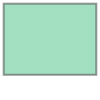

In [11]:
ds_hds = datamesh.get_datasource("oceanum_wave_cali_era5_spec")
x0, y0, x1, y1 = ds_hds.bounds
ds_hds.geom

In [12]:
datasources = [ds for ds in list(cat_ndbc) if ds_hds.geom.contains(ds.geom)]
len(datasources)

25

### 3.4. Plot model snapshot and buoys

#### Query a grid snapshot from the parameters datasource for plotting

In [13]:
query = {
    "datasource": "oceanum_wave_cali_era5_grid",
    "variables": ["hs", "depth"],
    "timefilter": {"type": "range", "times": ["20240101T00", "20240101T00"]},
}
cali = datamesh.query(query).squeeze()
cali

<xarray.Dataset> Size: 327kB
Dimensions:    (latitude: 176, longitude: 231)
Coordinates:
  * latitude   (latitude) float32 704B 31.3 31.32 31.34 ... 34.76 34.78 34.8
  * longitude  (longitude) float32 924B -121.0 -121.0 -121.0 ... -116.4 -116.4
    time       datetime64[ns] 8B 2024-01-01
Data variables:
    hs         (latitude, longitude) float32 163kB 2.939 2.94 2.942 ... nan nan
    depth      (latitude, longitude) float32 163kB 4.057e+03 3.969e+03 ... nan
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    model:                   41.31A
    project:                 California 2km
    run:                     cali
    _coordinates:            {"t":"time","x":"longitude","y":"latitude"}
    _request_size:           326884

#### Plotting

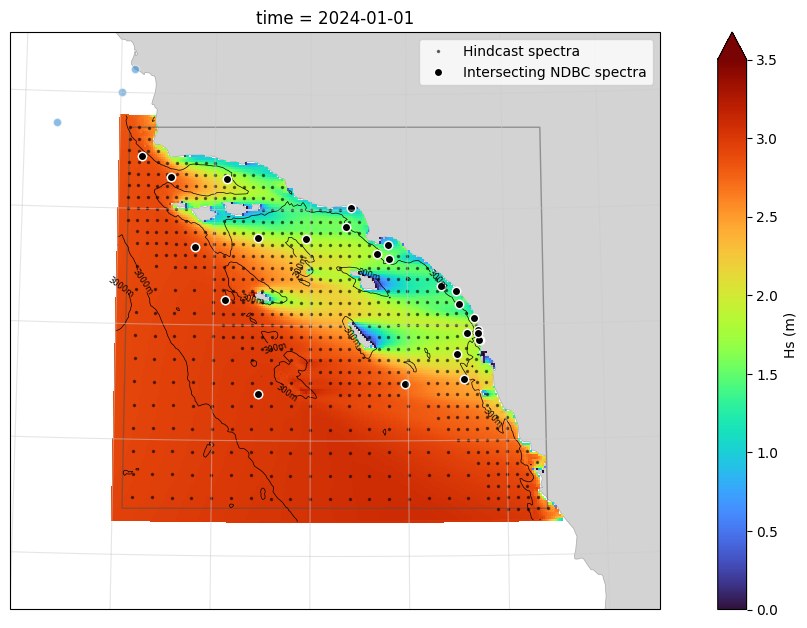

In [14]:
projection = ccrs.TransverseMercator(central_longitude=float(x1 + x0) / 2)

xbcali = [ds.geom.x for ds in datasources]
ybcali = [ds.geom.y for ds in datasources]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))

# Show hindcast grid snapshot
cali.hs.plot(ax=ax, cmap="turbo", vmin=0, vmax=3.5, cbar_kwargs=dict(label="Hs (m)"), transform=transform)
c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=transform)
c.clabel(fmt="%0.0fm", fontsize=6)

# Show the hindcast spectra locations
coords = all_coords["oceanum_wave_cali_era5_spec"]
ax.plot(coords.lon, coords.lat, ".", markersize=3, color="0.0", alpha=0.5, transform=transform, label="Hindcast spectra")

# Show the buoy locations
ax.plot(xb, yb, "wo", markerfacecolor="#187bcd", alpha=0.5, transform=transform)
ax.plot(xbcali, ybcali, "wo", markerfacecolor="k", alpha=1.0, transform=transform, label="Intersecting NDBC spectra")

# Show the land mask
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)

# Show spectra dataset bounds
geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=transform)

ax.legend(loc=1)
ax.set_extent([-122.0, -115.5, 30.5, 35.5])
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

### 3.5. Query and compare hindcast and NDBC spectra

Query spectra from the California 2 km hindcast and from intersecting NDBC buoys. Calculate integrated wave parameters using the [wavespectra](https://github.com/wavespectra/wavespectra) library to compare

#### Functions to read and colocate the data

In [15]:
def query_ndbc(datasource, t0=None, t1=None) -> xr.Dataset:
    """Query 1D NDBC buoy data and convert to wavespectra format to easily calculate spectral parametes."""
    query = {
        "datasource": datasource,
        "variables": ["spectral_wave_density"],
        "timefilter": {"type": "range", "times": [t0, t1]},
    }
    return datamesh.query(query).squeeze()


def query_hds(dset_ndbc, datasource="oceanum_wave_cali_era5_spec") -> xr.Dataset:
    """Query hindcast timeseries at the location and times of an NDBC buoy dataset."""
    t0, t1 = dset_ndbc.time.to_index().to_pydatetime()[[0, -1]]
    
    query = {
        "datasource": datasource,
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[float(dset_ndbc.longitude), float(dset_ndbc.latitude)]],
                },
            },
        },
    }
    return datamesh.query(query).squeeze()


def get_colocs(datasource, stats=["hs", "tp"], t0=None, t1=None) -> pd.DataFrame:
    """Read and colocate data obs and hindcast data.

    Parameters
    ----------
    datasource (str)
        Datamesh datasource id of the NDBC spectra station.
    stats (list):
        Integrated parameters to calculate with wavespectra.
    t0 (str):
        Start time to query time series from.
    t1 (str):
        End time to query timeseries until.

    Return
    ------
    df (pd.DataFrame)
        Colocations of integrated wave parameters from obs and hindcast.

    """
    # Read the data
    dset_obs = query_ndbc(datasource, t0, t1).chunk(time=8192)
    dset_hds = query_hds(dset_obs).chunk(time=8192)

    # Convert to wavespectra convention
    dset_obs = read_dataset(dset_obs, directional=False)

    # Calculate integrated parameters and resample
    df_obs = dset_obs.spec.stats(stats).to_pandas().resample("1h").mean()
    df_hds = dset_hds.spec.stats(stats).to_pandas().resample("1h").mean()

    # Make colocs
    df = pd.concat([df_obs[stats], df_hds[stats]], axis=1).dropna()
    df.columns = [f"{v}_obs" for v in stats] + [f"{v}_hds" for v in stats]
    df["lon_obs"] = df_obs.longitude
    df["lat_obs"] = df_obs.latitude
    df["lon_hds"] = df_hds.lon
    df["lat_hds"] = df_hds.lat

    return df

#### Functions to analyse the data

In [16]:
def nsamp(df: pd.DataFrame):
    """Number of colocations."""
    return df.dropna().shape[0]


def mad(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Mean absolute difference MAD."""
    return (df[y] - df[x]).abs().mean()


def rmsd(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Root-mean-square difference RMSD."""
    return np.sqrt(((df[y] - df[x])**2).mean())


def bias(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Bias."""
    return (df[y] - df[x]).mean()


def si(df: pd.DataFrame, x: str = "hs_obs", y: str = "hs_hds"):
    """Scatter Index."""
    return np.sqrt((((df[y] - df[x]) - bias(df, x, y))**2).mean() ) / df[x].mean()


def errors(df, x: str = "hs_obs", y: str = "hs_hds"):
    """Return a label with error summary for plotting."""
    return f"Bias: {bias(df, x, y):0.2f} m\nMAD: {mad(df, x, y):0.2f} m\nRMSD: {rmsd(df, x, y):0.2f} m\nSI: {si(df, x, y):0.2f}\nN: {nsamp(df):0.0f}"

#### Functions to plot the data

In [17]:
def plot_map(df, datasource_id, ax):
    """Plot map showing the location at the NDBC datasource."""

    # Bathy contour
    c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=transform)
    c.clabel(fmt="%0.0fm", fontsize=6)

    # Buoy location
    ax.plot(xb, yb, "o", color="#187bcd", alpha=0.3, markersize=5, transform=transform)
    ax.plot(df.lon_obs, df.lat_obs, "o", color="#187bcd", markersize=5, alpha=0.7, transform=transform, label="NDBC")
    ax.plot(df.lon_hds, df.lat_hds, "o", color="#d84418", markersize=5, alpha=0.7, transform=transform, label="Hindcast")
    ax.legend(loc=1)

    # Show features
    ax.add_feature(cfeature.LAND.with_scale("10m"))
    geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=transform)

    # Axis settings
    buff = 0.1
    ax.set_extent([x0-buff, x1+buff, y0-buff, y1+buff])
    ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);
    ax.set_title(f"{datasource_id.upper().replace('_', ' ')}")

    return ax


def plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs"):
    """Plot scatter of obs and hindcast."""

    # Set xlim
    xmax = df[[x, y]].max().max() * 1.1
    xlim = ylim = [0, xmax]

    # Scatter points
    p = ax.scatter(df[x], df[y], s=5, c="#187bcd", vmin=0, vmax=20, alpha=0.5, cmap="turbo")

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs NDBc (m)")
    ax.set_ylabel("Hs hindcast (m)");

    return ax


def plot_data(df, datasource_id, fac=0.7):
    """Plot map with station locations and scatter of obs and hindcast."""

    fig = plt.figure(figsize=(10*fac, 18*fac))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.0, 1.0])

    # Map
    projection = ccrs.TransverseMercator(central_longitude=float(x0 + x1)/2)
    ax = plt.subplot(gs[0], projection=projection)
    ax = plot_map(df, datasource_id, ax)

    # Scatter
    ax = plt.subplot(gs[1])
    ax = plot_scatter(df, ax, x="hs_obs", y="hs_hds", c="tp_obs")

    fig.tight_layout()
    return fig

#### Compare the last year at few selected locations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:59<00:00, 24.00s/it]


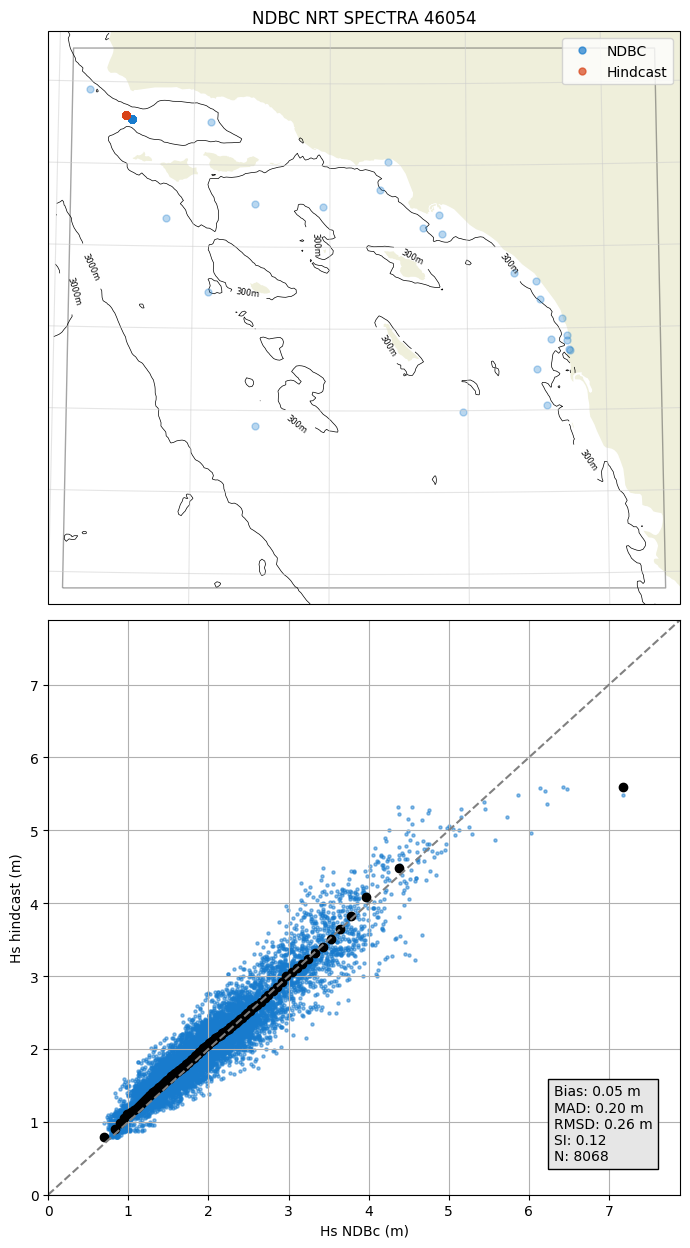

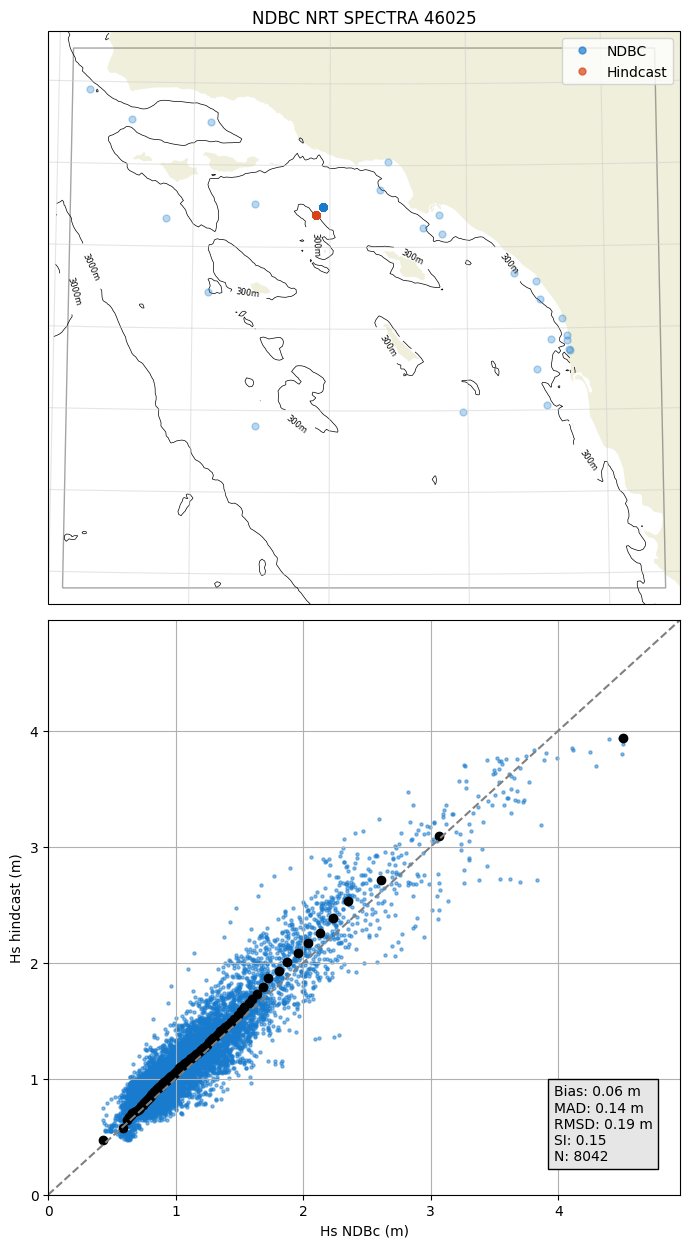

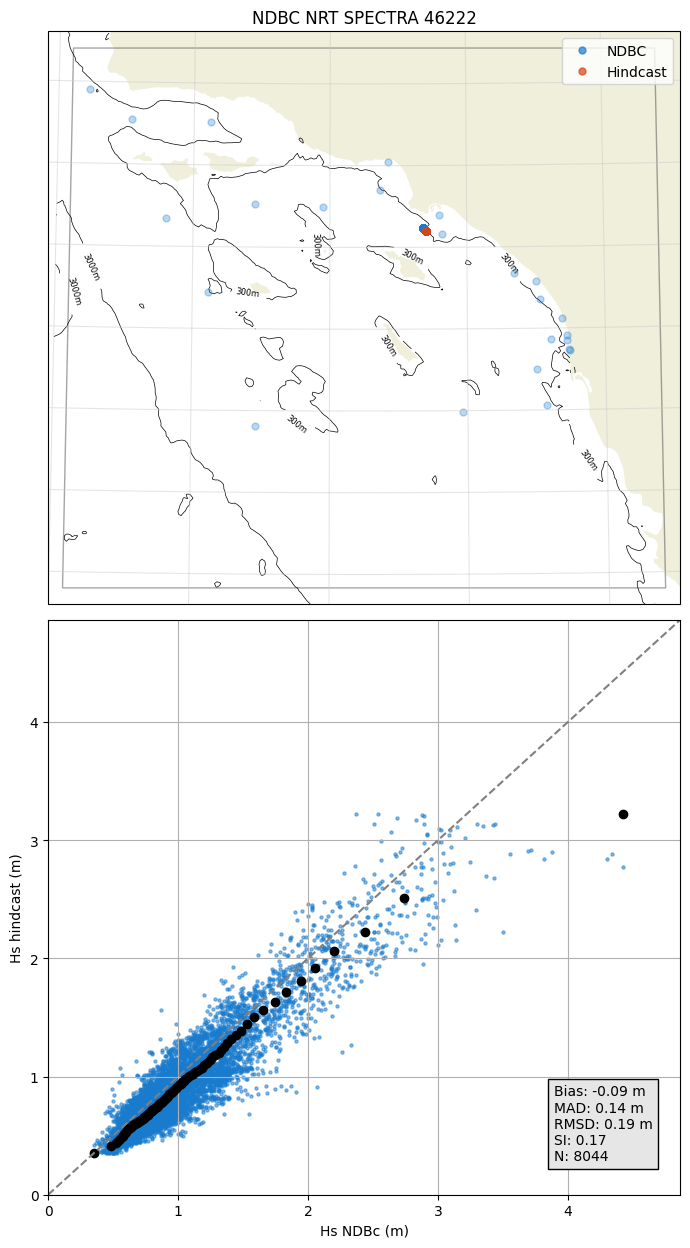

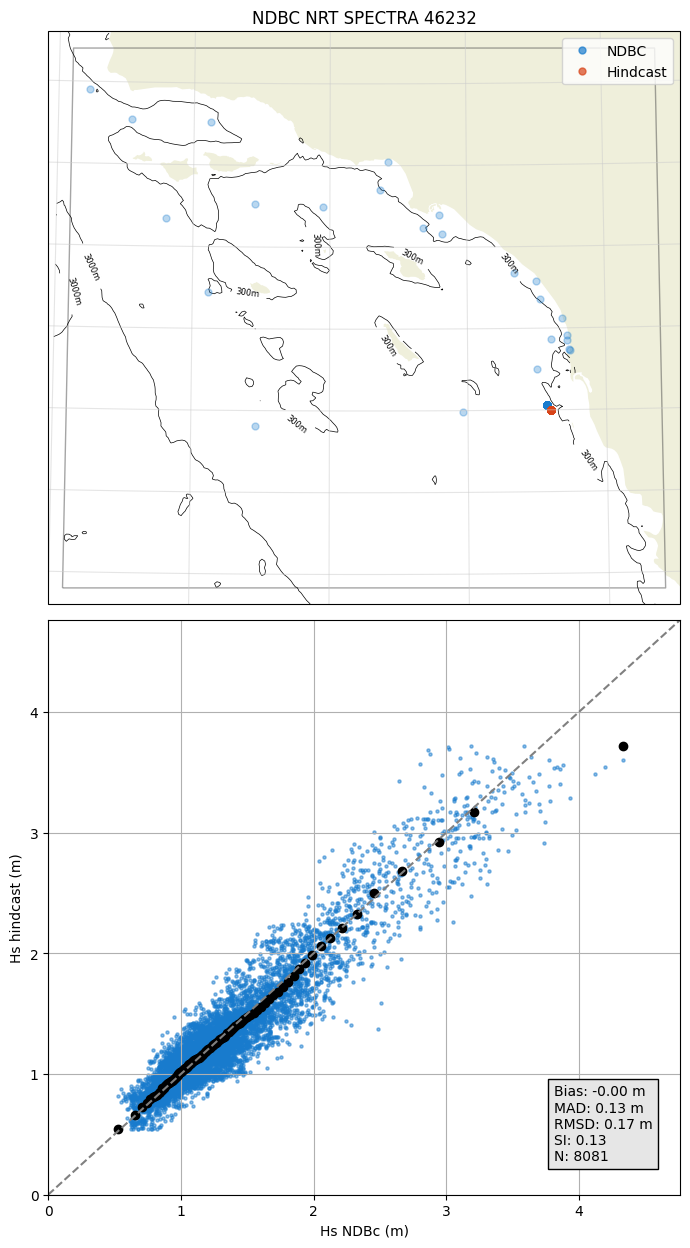

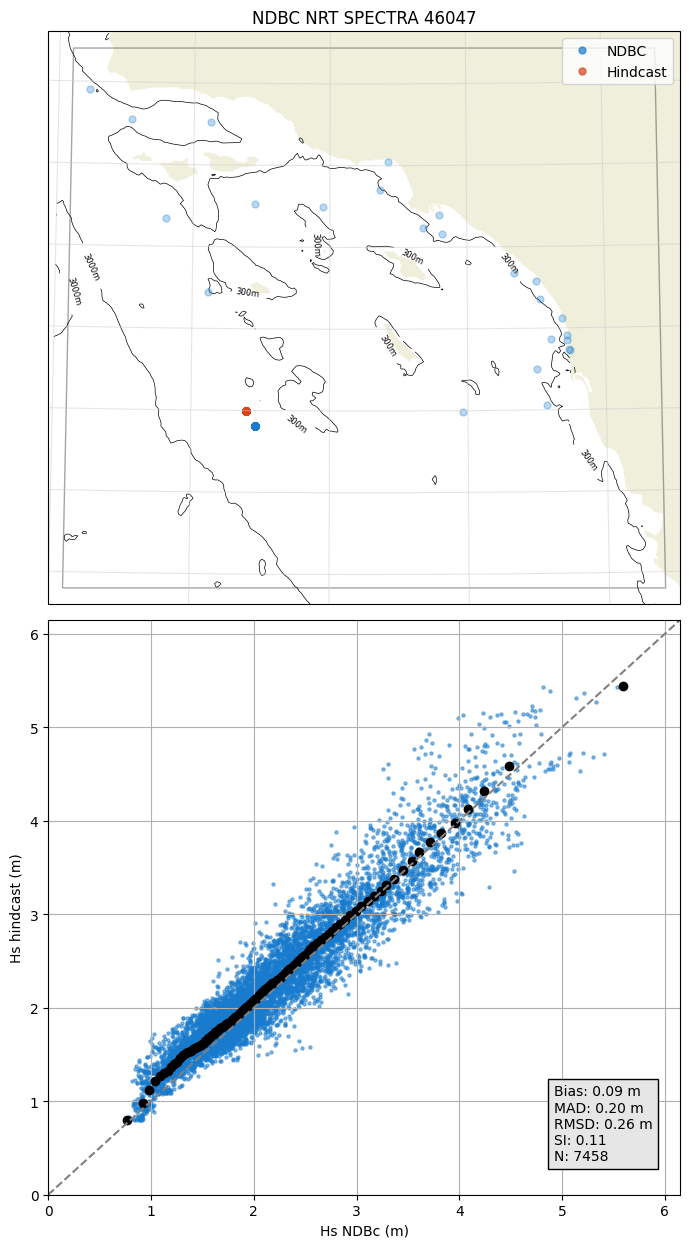

In [18]:
t0 = datetime.now() - timedelta(days=365)

selected_stations = ["46054", "46025", "46222", "46232", "46047"]

data = {}
for station in tqdm(selected_stations):
    datasource = f"ndbc_nrt_spectra_{station}"
    df = get_colocs(datasource, t0=t0)
    data.update({station: df})
    fig = plot_data(df, datasource)


#### Visualise the timeseries

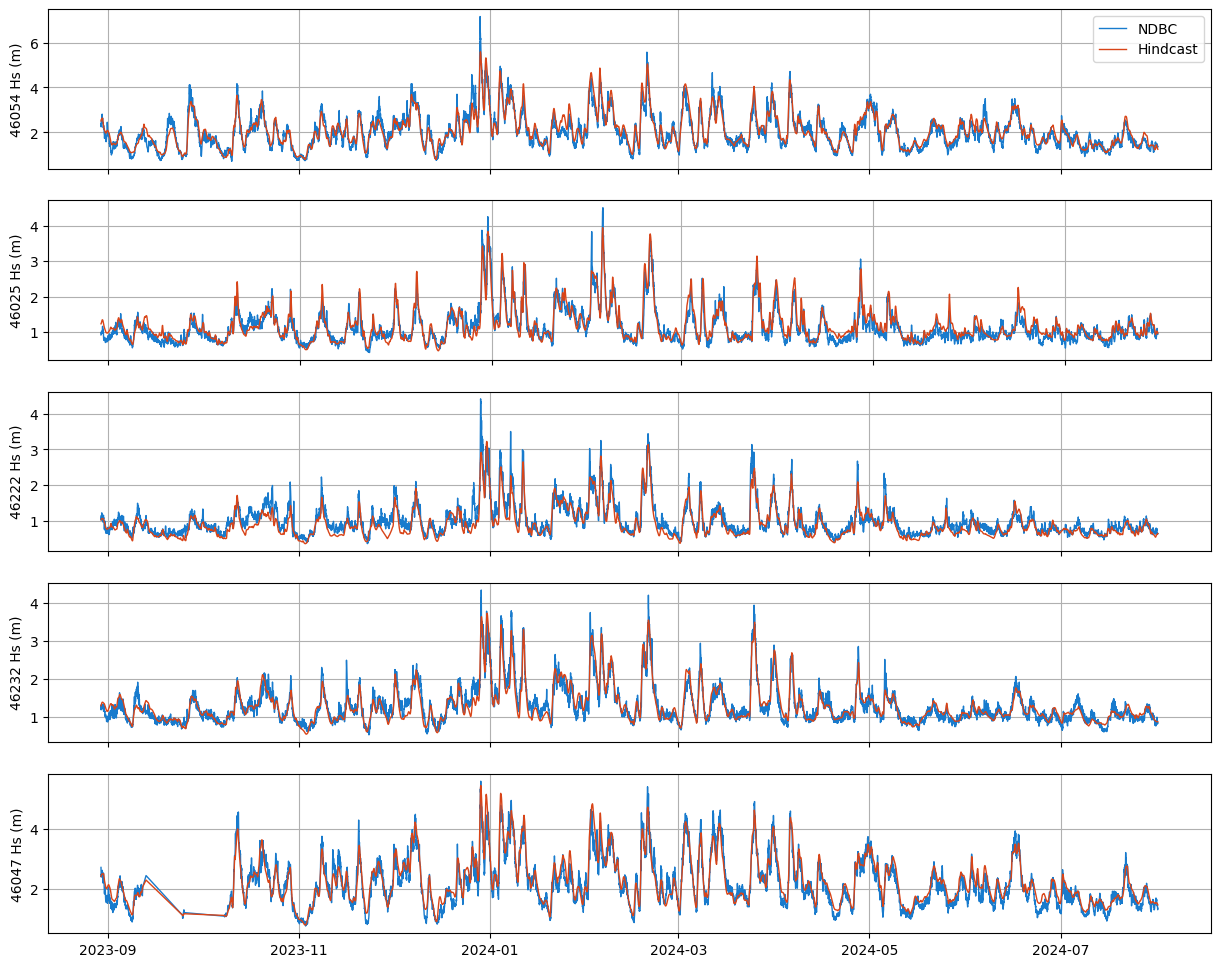

In [19]:
n = len(data)

fig, axs = plt.subplots(n, 1, figsize=(15, 12))

for ind, (station, df) in enumerate(data.items()):
    ax = axs[ind]
    ax.plot(df.index, df.hs_obs, linewidth=1.0, color="#187bcd", label="NDBC")
    ax.plot(df.index, df.hs_hds, linewidth=1.0, color="#d84418", label="Hindcast")
    ax.set_ylabel(f"{station} Hs (m)")
    ax.grid()
    if ind < len(data) - 1:
        ax.set_xticklabels("")
    if ind == 0:
        ax.legend(loc=1)

## 4. Compare against satellite altimeter

Compare the hindcast against the homogenised, calibrated satellite altimeter dataset of [Ribal and Young (2019)](https://www.nature.com/articles/s41597-019-0083-9)

#### Analyse the full data data record from station 46047 farther from the coast

2012-11-28 21:00:00  --  2024-07-17 02:00:00


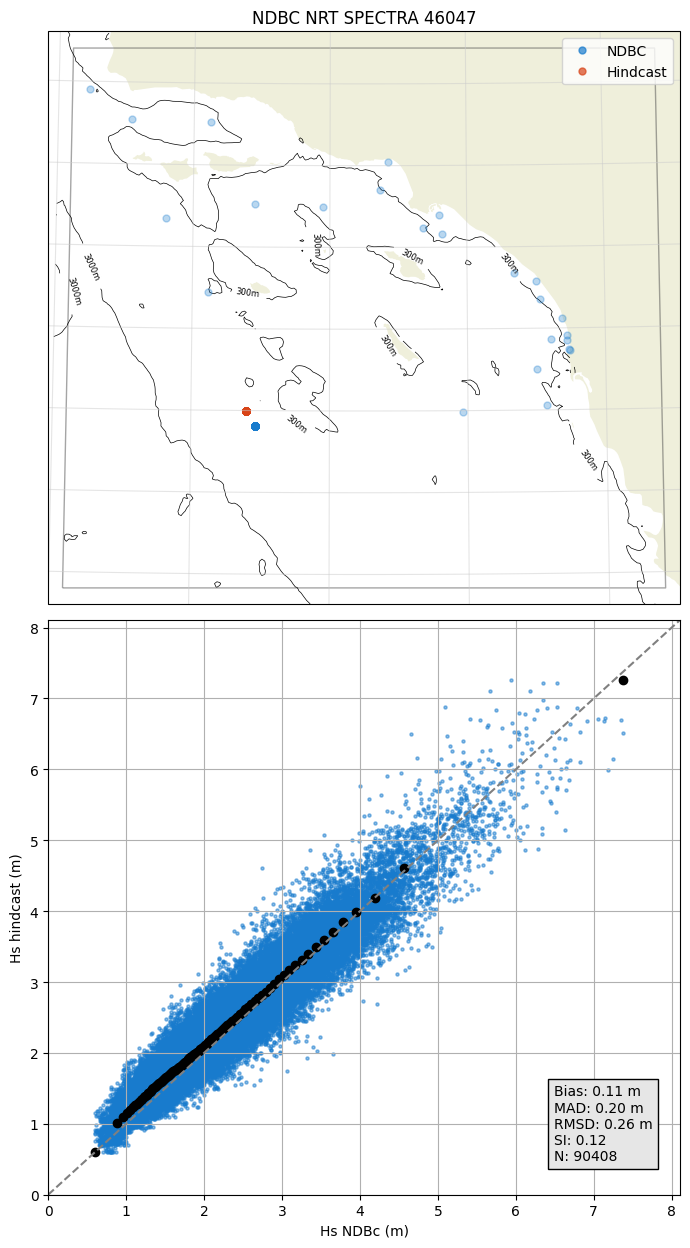

In [20]:
datasource = "ndbc_nrt_spectra_46047"
df = get_colocs(datasource)
print(df.index.min(), " -- ", df.index.max())
fig = plot_data(df, datasource)

#### Load satellite altimeter data within a 1-degree square centered at the chosen location

In [21]:
lon = float(df.lon_obs.mean()) % 360
lat = float(df.lat_obs.mean())
win = 0.5

query = dict(
    datasource="imos_wave_wind",
    variables=["swh_ku_cal", "swh_ku_quality_control", "platform"],
    geofilter={"type": "bbox", "geom":[lon-win, lat-win, lon+win, lat+win]}
)
dfsat = datamesh.query(query)
dfsat["longitude"] = dfsat.longitude - 360
display(dfsat.shape)
dfsat.head()

(69270, 7)

,time,longitude,latitude,swh_ku_cal,swh_ku_quality_control,platform,geometry
0,1994-06-25 18:51:22.453125,-120.01126,31.916200,2.440,1.0,ERS-1,POINT (239.98874 31.91620)
1,1991-12-18 18:51:53.656245,-120.01556,32.892730,1.950,1.0,ERS-1,POINT (239.98444 32.89273)
2,1991-12-18 18:51:54.640629,-120.03194,32.834904,2.370,1.0,ERS-1,POINT (239.96806 32.83490)
3,1992-06-10 18:51:56.281246,-120.00351,32.517254,0.620,1.0,ERS-1,POINT (239.99649 32.51725)
4,1992-07-15 18:52:00.906246,-120.01292,32.461365,1.402,1.0,ERS-1,POINT (239.98708 32.46136)


#### Keep only the "good" data (see https://www.nature.com/articles/s41597-019-0083-9)

In [22]:
dfsat = dfsat.loc[dfsat.swh_ku_quality_control == 1]
dfsat.shape

(62803, 7)

#### Plot model snapshot with buoys and satellite passes

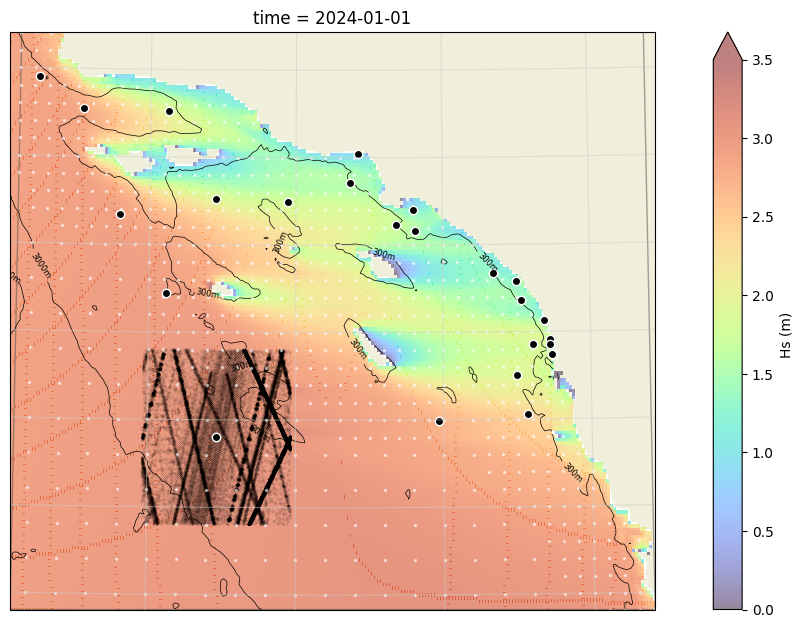

In [23]:
projection = ccrs.TransverseMercator(central_longitude=float(x1 + x0) / 2)

xbcali = [ds.geom.x for ds in datasources]
ybcali = [ds.geom.y for ds in datasources]

fig, ax = plt.subplots(figsize=(15, 7.5), subplot_kw=dict(projection=projection))

# Show hindcast grid snapshot
cali.hs.plot(ax=ax, cmap="turbo", vmin=0, vmax=3.5, alpha=0.5, cbar_kwargs=dict(label="Hs (m)"), transform=transform)
c = cali.depth.plot.contour(ax=ax, levels=[300, 3000], colors="0.0", linewidths=0.5, transform=transform)
c.clabel(fmt="%0.0fm", fontsize=6)

# Show satellite passes
ax.plot(dfsat.longitude, dfsat.latitude, ".k", markersize=0.2, alpha=0.5, transform=transform)

# Show the hindcast spectra locations
ax.plot(coords.lon, coords.lat, ".", markersize=3, color="1.0", alpha=0.5, transform=transform)

# Show the buoy locations
ax.plot(xb, yb, "wo", markerfacecolor="k", alpha=0.5, transform=transform)
ax.plot(xbcali, ybcali, "wo", markerfacecolor="k", alpha=1.0, transform=transform)

# Show the land mask
ax.add_feature(cfeature.LAND)

# Show spectra dataset bounds
geopandas.GeoSeries(ds_hds.geom).plot(ax=ax, facecolor="none", edgecolor="0.3", alpha=0.5, transform=transform)

ax.set_extent([x0, x1, y0, y1])
ax.gridlines(draw_labels=False, color="0.8", alpha=0.5);

#### Colocate the data

Interpolate hindcast at the satellite times

In [31]:
# Tidy up satellite dataframe
dfall = dfsat[["time", "swh_ku_cal", "longitude", "latitude", "platform"]].set_index("time")
dfall["platform"] = dfall.platform.str.strip()

# Interpolate model and ndbc obs at satellite times using xarray
ds = xr.Dataset.from_dataframe(df)
dfall["swh_obs"] = ds.hs_hds.interp(time=dfall.index).to_pandas()
dfall["swh_hds"] = ds.hs_obs.interp(time=dfall.index).to_pandas()

dfall.tail()

,swh_ku_cal,longitude,latitude,platform,swh_obs,swh_hds
time,,,,,,
2023-12-31 01:44:09.999996,4.064,-119.15656,32.554844,SENTINEL-6A,4.730357,3.654390
2023-12-31 01:44:11.000001,4.550,-119.13034,32.507942,SENTINEL-6A,4.730335,3.654398
2023-12-31 01:44:11.999995,3.690,-119.10416,32.461033,SENTINEL-6A,4.730314,3.654407
2023-12-31 01:44:13.000000,3.554,-119.07800,32.414116,SENTINEL-6A,4.730292,3.654416
2023-12-31 01:44:14.000004,3.849,-119.05190,32.367190,SENTINEL-6A,4.730271,3.654424


#### Plot the data

In [34]:
def plot_satellite_scatter(df, x, y, ax):
    """Plot scatter of satellite vs NDBC or hindcast colocations."""
    xlim = ylim = [0, 8]

    # Plot points
    platforms = dfall.platform.unique()
    for platform in platforms:
        p = ax.scatter(df.loc[df.platform == platform][x], df[df.platform == platform][y], s=5, vmin=None, vmax=None, alpha=1.0, label=platform)

    ax.legend(fontsize=7)

    # Calculate and plot quantiles
    dfq = df[[x, y]].quantile(q=np.arange(0, 1.01, 0.01))
    ax.plot(dfq[x], dfq[y], "ok")

    # Equality line
    ax.plot(xlim, ylim, "--", color="0.5")

    # Show error statistics
    ax.annotate(errors(df, x, y), xy=(0.80, 0.06), xycoords="axes fraction", fontsize=10, color="0.0", bbox=dict(facecolor="0.9"))

    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("Hs satellite (m)")
    yname = "NDBC" if "obs" in y else "hindcast"
    ax.set_ylabel(f"Hs {yname} (m)");

    return ax

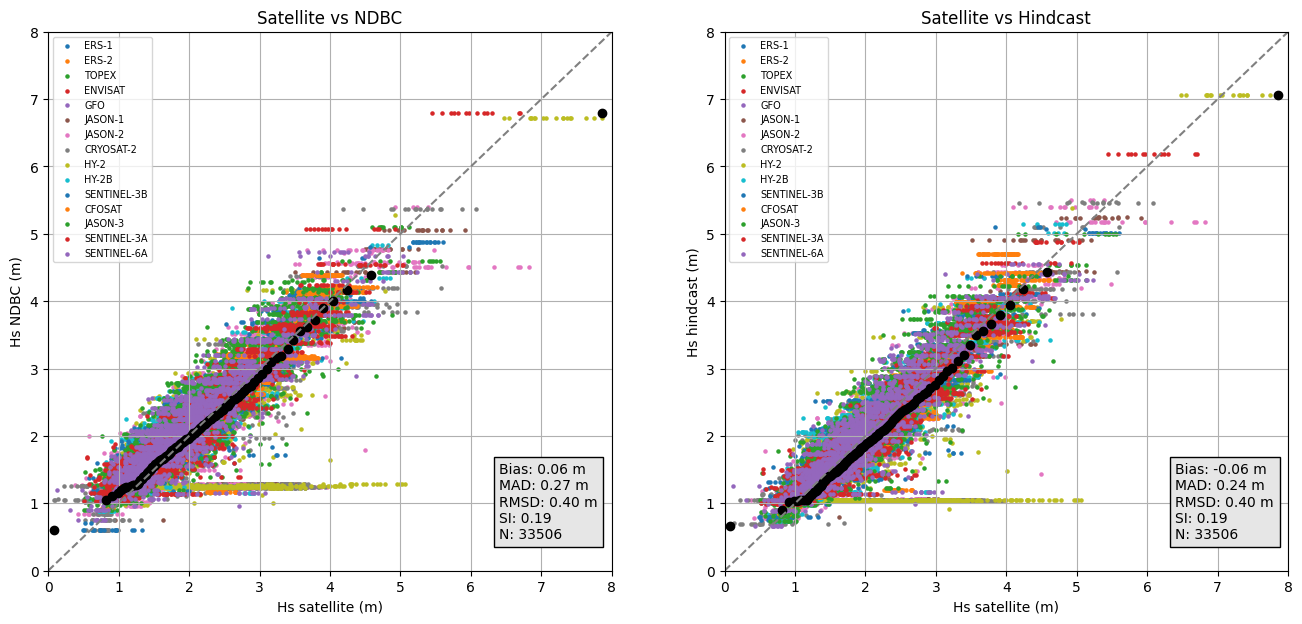

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# Satellite vs NDBC
ax = plot_satellite_scatter(dfall, x="swh_ku_cal", y="swh_obs", ax=axs[0])
ax.set_title("Satellite vs NDBC")

# Satellite vs hindcast
ax = plot_satellite_scatter(dfall, x="swh_ku_cal", y="swh_hds", ax=axs[1])
t = ax.set_title("Satellite vs Hindcast")